# Провести анализ и дать оценку A/B-теста

## Задача:

- Оцените корректность проведения теста.
- Проанализируйте результаты теста.

Чтобы оценить корректность проведения теста, проверьте:

- пересечение выборок A и B,
- совпадение теста и маркетинговых событий, другие проблемы временных границ теста.

## Техническое задание

- Название теста: 'recommender_system_test';
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки теста: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие **product_page**,
    - просмотры корзины — **product_cart**,
    - покупки — **purchase**.

## Описание датасетов

**ab_project_marketing_events_us** — календарь маркетинговых событий на 2020 год.

Структура файла:

- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

**final_ab_new_users_upd_us** — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

**final_ab_events_upd_us** — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время покупки;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.

**final_ab_participants_upd_us** — таблица участников тестов.

Структура файла:

- `ser_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

# Импорт библиотек и выгрузка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import scipy
from scipy.stats import norm, chi2_contingency

from plotly import graph_objects as go
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "svg"

import os
import glob
from dotenv import load_dotenv
from pyod.models.knn import KNN

pd.options.display.float_format = '{:0.3f}'.format
pd.options.mode.chained_assignment = None
pd.set_option('display.expand_frame_repr', False)

sns.set_theme(context='paper',
              palette='muted',
              style='whitegrid',
              font_scale=1.1,)

plt.rcParams.update({'lines.linewidth': 1.25,
                     'grid.linewidth': 0.5,
                     'grid.alpha': 0.5,
                     'figure.constrained_layout.use': True,
                     'figure.figsize': (10, 4)})

%config InlineBackend.figure_format = 'retina'

Загрузим и посмотрим данные.

In [2]:
url = './datasets/'
files = glob.glob(os.path.join(url, '*.csv'))
files

['./datasets\\ab_project_marketing_events_us.csv',
 './datasets\\final_ab_events_upd_us.csv',
 './datasets\\final_ab_new_users_upd_us.csv',
 './datasets\\final_ab_participants_upd_us.csv']

In [3]:
marketing_events = pd.read_csv(files[0], parse_dates=[2,3])
events = pd.read_csv(files[1], parse_dates=[1])
new_users = pd.read_csv(files[2], parse_dates=[1])
participants = pd.read_csv(files[3])

Оценим есть ли пропуски или дубликаты в данных.

In [4]:
def df_analysis(df, sep_len=77):
    df, df_name = df
    # Стандартная обработка - перевод признаков к pythonic way.
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    
    print(f'{df_name}'.center(sep_len, '-'))
    if len(df) < 20:
        display(df)
    else:
        display(df.head())
        
    print('Всего объектов:\t', df.shape[0])
    print(f''.center(sep_len, '-'))
    display(pd.DataFrame({
        'type': df.dtypes,
        'nan': df.isna().mean()
    }))
    
    print(''.center(sep_len, '-'),
    f'Количество явных дубликатов:\t{df.duplicated().sum()}',
    f'Количество пропусков в данных:\t{df.isna().sum().sum()}',
    ''.center(sep_len, '-'), sep='\n', end='\n\n')
    
for df in [(marketing_events, 'marketing_events'),
           (events, 'events'),
           (new_users, 'new_users'),
           (participants, 'participants')]:
    df_analysis(df)

-------------------------------marketing_events------------------------------


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


Всего объектов:	 14
-----------------------------------------------------------------------------


,type,nan
name,object,0.000
regions,object,0.000
start_dt,datetime64[ns],0.000
finish_dt,datetime64[ns],0.000


-----------------------------------------------------------------------------
Количество явных дубликатов:	0
Количество пропусков в данных:	0
-----------------------------------------------------------------------------

------------------------------------events-----------------------------------


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.990
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.990
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.990
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.990
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.990


Всего объектов:	 423761
-----------------------------------------------------------------------------


,type,nan
user_id,object,0.000
event_dt,datetime64[ns],0.000
event_name,object,0.000
details,float64,0.858


-----------------------------------------------------------------------------
Количество явных дубликатов:	0
Количество пропусков в данных:	363447
-----------------------------------------------------------------------------

----------------------------------new_users----------------------------------


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


Всего объектов:	 58703
-----------------------------------------------------------------------------


,type,nan
user_id,object,0.000
first_date,datetime64[ns],0.000
region,object,0.000
device,object,0.000


-----------------------------------------------------------------------------
Количество явных дубликатов:	0
Количество пропусков в данных:	0
-----------------------------------------------------------------------------

---------------------------------participants--------------------------------


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test


Всего объектов:	 14525
-----------------------------------------------------------------------------


,type,nan
user_id,object,0.000
group,object,0.000
ab_test,object,0.000


-----------------------------------------------------------------------------
Количество явных дубликатов:	0
Количество пропусков в данных:	0
-----------------------------------------------------------------------------



> Явные дубликаты отсутствуют, пропуски есть только в events.

# EDA

Сначала удостоверимся, что группы 'A' и 'B' не пересекаются.

> 441 id представлен в обоих выборках, поэтому исключим их.

In [5]:
ab_crossing = set(participants.loc[participants.group == 'A', 'user_id']) \
    & set(participants.loc[participants.group == 'B', 'user_id'])

len(ab_crossing)

441

Оставим только участников тестирования рекомендательной системы.

In [6]:
ab_crossing.update(
    participants[participants.ab_test != 'recommender_system_test'].user_id.tolist()
)

len(ab_crossing)

10850

Часть пользователей зарегистрировались раньше запуска теста или позже даты остановки набора новых пользователей. Их тоже следует исключить. Кроме того нас итересует только регион EU.

In [7]:
ab_crossing.update(
    new_users.query('first_date < "2020-12-07" or first_date > "2020-12-21"').user_id.tolist()
)
ab_crossing.update(
    new_users.query('region != "EU"').user_id.tolist()
)

len(ab_crossing)

29085

In [8]:
participants = participants.query('~user_id.isin(@ab_crossing)').reset_index(drop=True)
new_users = new_users.query('~user_id.isin(@ab_crossing)').reset_index(drop=True)
events = events.query('~user_id.isin(@ab_crossing)').reset_index(drop=True)

Все участники тестирования представлены в new_users.

In [9]:
set(new_users.user_id).issuperset(set(participants.user_id))

True

В events пропуски есть у событий отличных от 'purchase', соответственно можно заполнить их нулями.

In [10]:
events[events.details.isna()].event_name.value_counts()

login           93873
product_page    62010
product_cart    31038
Name: event_name, dtype: int64

In [11]:
events.fillna(0, inplace=True)

Проверим временной диапазон events.

> Часть событий отсутствует, а значит потребуется вычесть из даты регистрации 5 последних дней.

In [12]:
events.event_dt.agg(['min', 'max'])

min   2020-12-07 00:00:33
max   2020-12-30 23:02:44
Name: event_dt, dtype: datetime64[ns]

Оставим маркетинговые события которые были в EU после 2020-12-07.

> Только одна маркетинговая компания попала на время теста.

In [13]:
marketing_events = marketing_events[
    marketing_events.regions.apply(lambda x: 'EU' in x.split(','))
]
marketing_events = marketing_events.query('finish_dt > "2020-12-07"')

marketing_events

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03


Объединим датафреймы.

In [14]:
df = new_users.merge(participants, on='user_id', how='left').copy()

После предварительной обработки заметно, что параметры тест отличаются от заданных.

* Участников теста в 2 раза меньше.
* Только 8.7% пользователей из региона EU направлены на тест.

In [15]:
print(f'Новых пользователей из региона EU: {1 - df.group.isna().mean():.2%}')
print(f'Количество участников теста: {len(df[~df.ab_test.isna()]):.0f}')

Новых пользователей из региона EU: 8.76%
Количество участников теста: 2594


Оставим только участников тестирования.

In [16]:
df.dropna(inplace=True)
events = events.query('user_id.isin(@df.user_id.tolist())')

* Следует проверить регистрации по времени для групп чтобы оценить на сколько 'Christmas&New Year Promo' могло повлиять на результат.

* Большинство пользователей в группе 'A' зарегистрировалось после 15 декабря, а значит подпадают под акцию, в то время как группа 'B' более равномерно распределена. Это может сказаться на результатах теста, придется убрать период после 25 декабря.

* Пользователей в группе 'A' значительно больше что способно повлиять на результат.

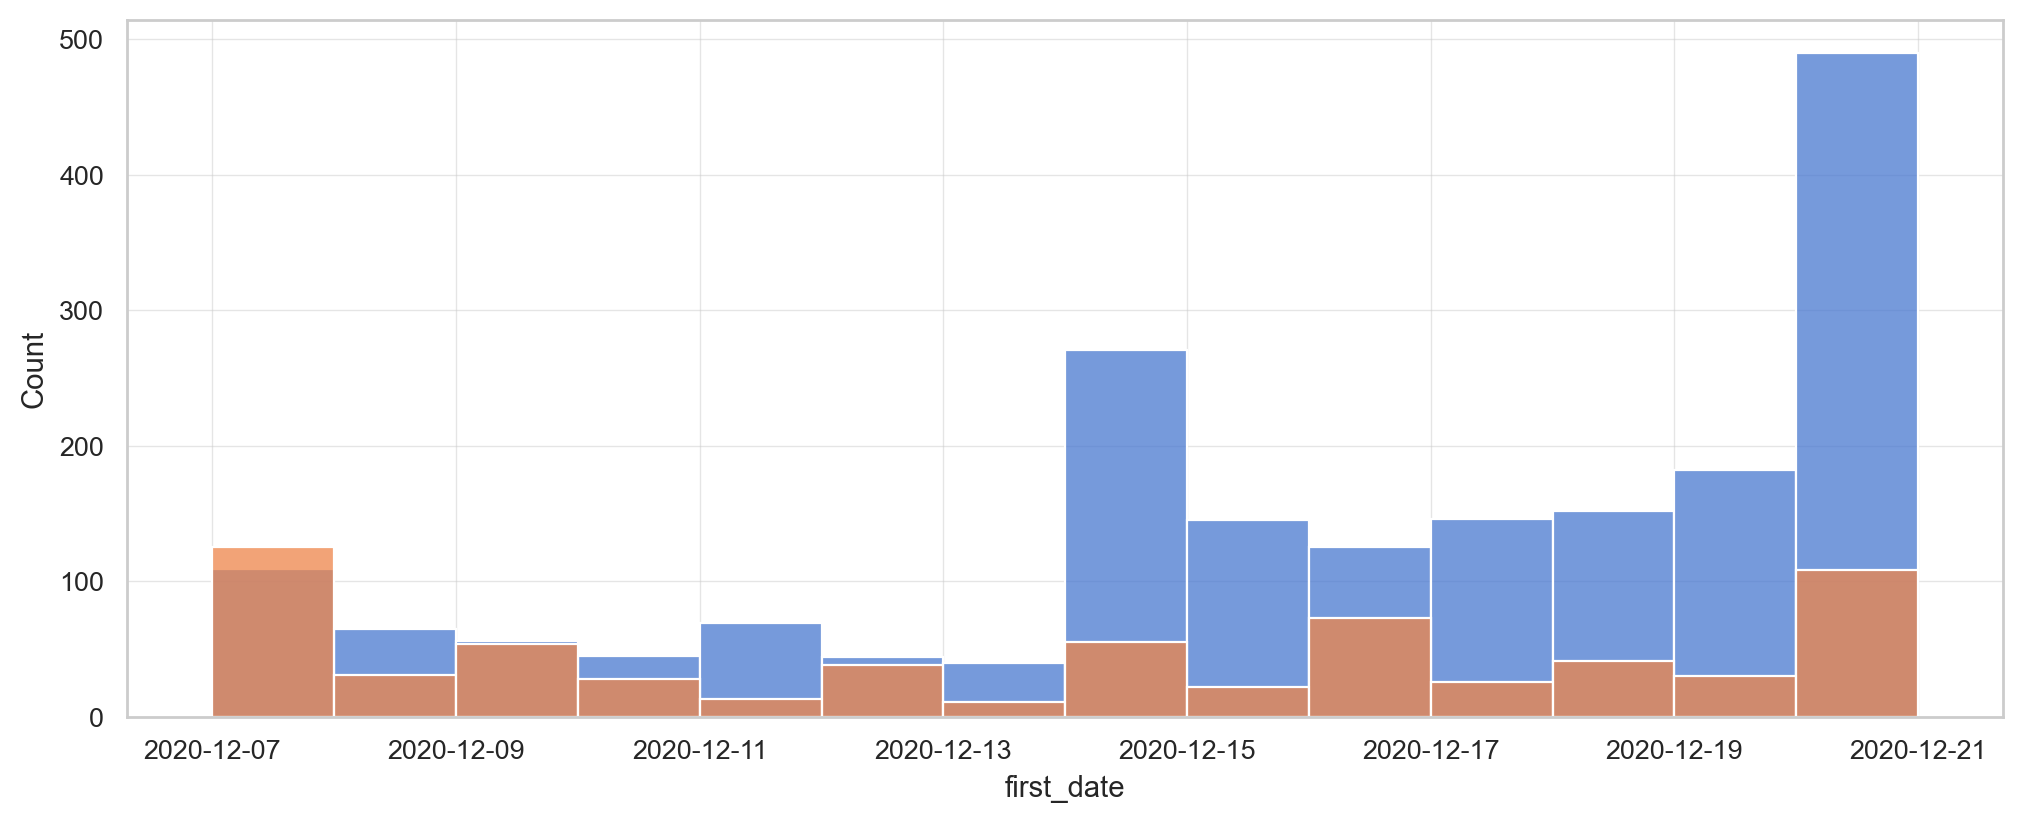

In [17]:
ax = sns.histplot(data=df[df.group == 'A'].first_date, binwidth=1)
sns.histplot(data=df[df.group == 'B'].first_date, ax=ax, binwidth=1);

Отфильтруем события до 25 декабря.

In [18]:
events = events.query('event_dt < "2020-12-25"')
events.shape

(15186, 4)

Теперь можно получить финальный датафрейм.

In [19]:
df = events.merge(df, on='user_id', how='left').reset_index(drop=True).copy()
df.drop(columns=['region', 'ab_test'], inplace=True)

print(df.shape)
df.head()

(15186, 7)


,user_id,event_dt,event_name,details,first_date,device,group
0,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.990,2020-12-07,Android,A
1,3C5DD0288AC4FE23,2020-12-07 19:42:40,purchase,4.990,2020-12-07,PC,A
2,49EA242586C87836,2020-12-07 06:31:24,purchase,99.990,2020-12-07,iPhone,B
3,A640F31CAC7823A6,2020-12-07 18:48:26,purchase,4.990,2020-12-07,PC,B
4,A9908F62C41613A8,2020-12-07 11:26:47,purchase,9.990,2020-12-07,PC,B


Оценим распределение по устройством. Везде наблюдается соотношение 1 к 3.

In [20]:
df.pivot_table(index='device', columns='group', values='user_id', aggfunc='count')

group,A,B
device,,
Android,5181,1633
Mac,1109,305
PC,2993,737
iPhone,2490,738


## Количество событий на пользователя

В группе 'A' на пользователя в среднем приходится на одно событие больше чем в 'B'.

In [21]:
df.groupby(['group', 'user_id']).agg({'event_dt': 'count'}) \
    .reset_index().groupby('group').agg({'event_dt': 'mean'})

,event_dt
group,
A,6.072
B,5.211


# Относительное распределение событий по дням

In [22]:
gr = df.groupby([pd.Grouper(key='event_dt', freq='d'), 'group'])

view = gr.agg(event_cnt=('event_dt', 'count')).reset_index()
view['unq_users'] = gr.agg(cnt=('user_id', 'nunique')).reset_index()['cnt']
view['ratio'] = view.event_cnt / view.unq_users

Несмотря на то что после 14 декабря в группе 'B' значительно возрастает число пользователей, отношение числа событий к числу уникальных пользователей сохраняется.

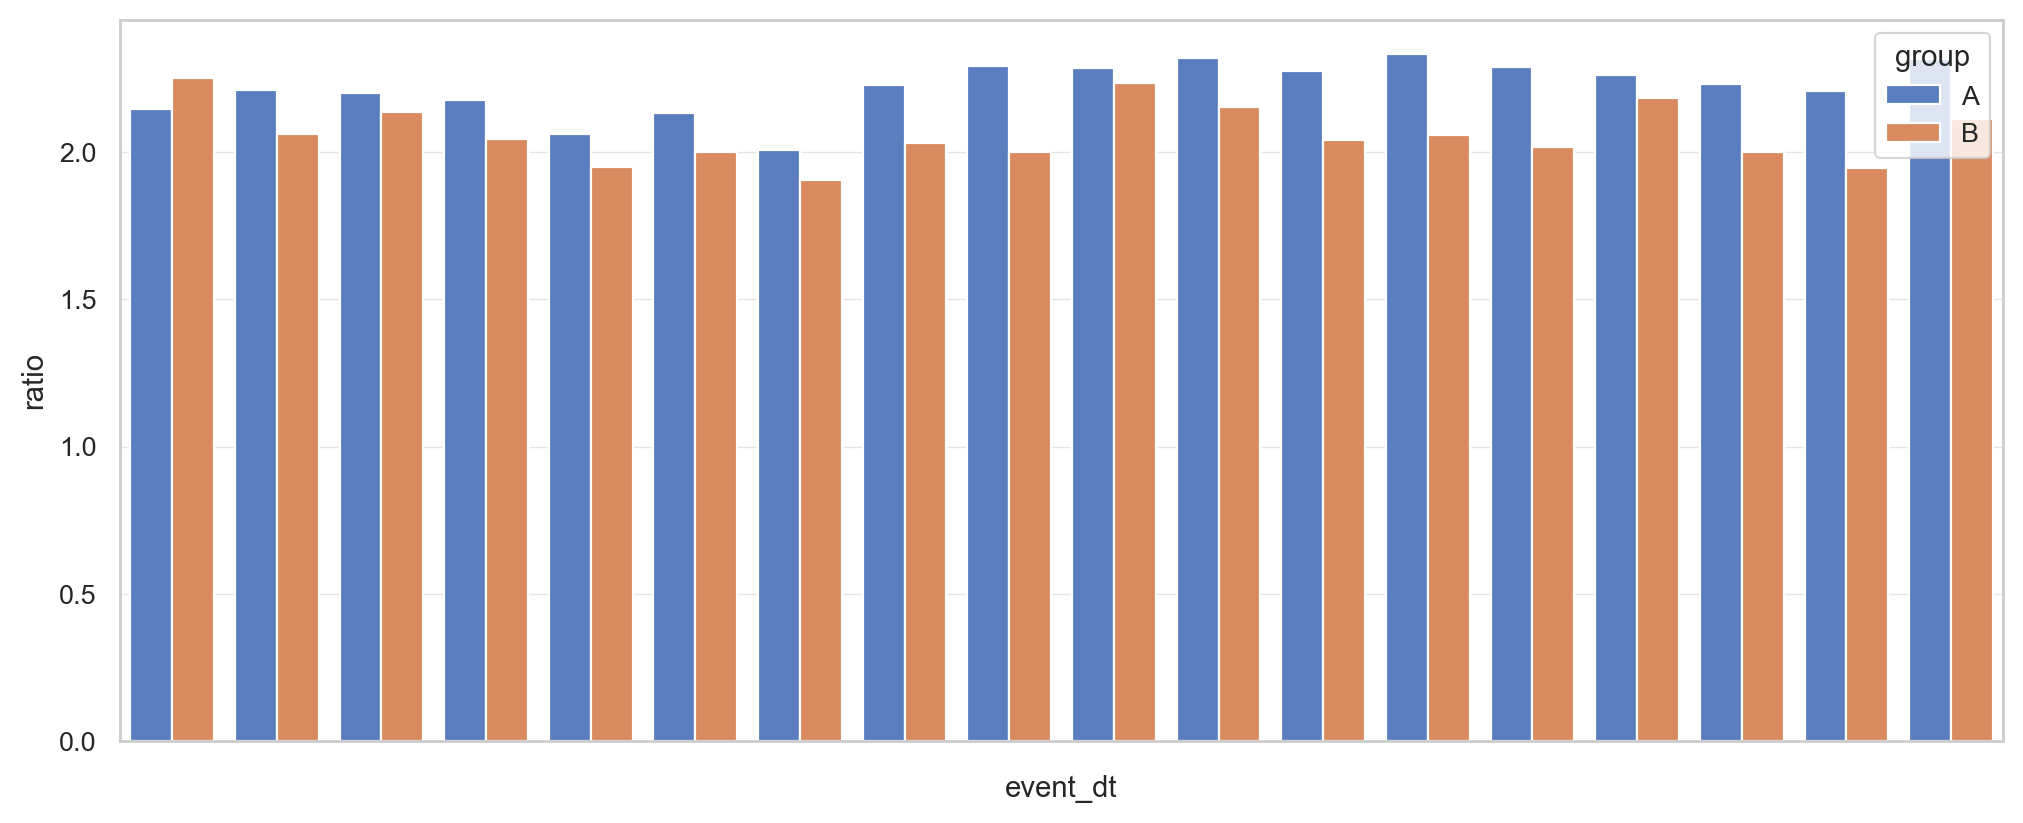

In [23]:
ax = sns.barplot(data=view, x='event_dt', y='ratio', hue='group')
ax.set_xticklabels('');

# Изменение конверсии в воронке на разных этапах

Построим воронку по событиям.

In [24]:
funnel = df.pivot_table(index=['event_name', 'group'],
                        values='user_id', aggfunc='count').reset_index()
funnel = funnel.sort_values('user_id', ascending=False)

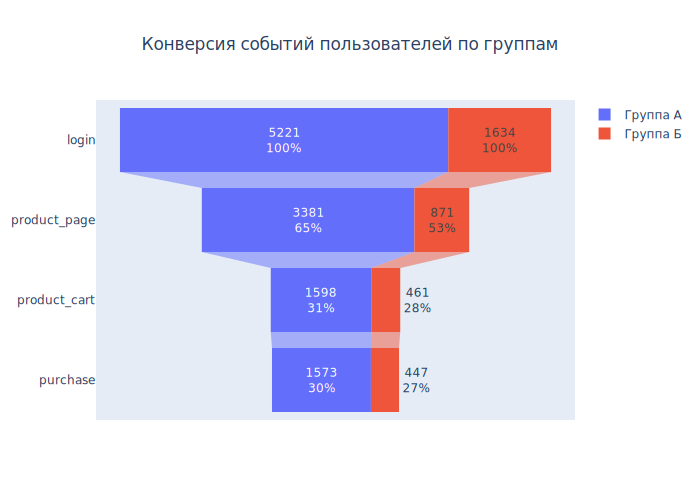

In [25]:
fig = go.Figure()
    
fig.add_trace(go.Funnel(
    name='Группа А',
    x=funnel.query('group == "A"')['user_id'],
    y=funnel.query('group == "A"')['event_name'],
    textinfo = "value+percent initial"))

fig.add_trace(go.Funnel(
    name='Группа Б',
    x=funnel.query('group == "B"')['user_id'],
    y=funnel.query('group == "B"')['event_name'],
    textinfo = "value+percent initial"))

fig.update_layout(
    title={'text': 'Конверсия событий пользователей по группам', 'x': 0.5})

fig.show()

## Выводы

* Только треть пользователей доходят до покупки.
* Большинство пользователей теряется на шаге перехода со страницы продукта в корзину товаров.

# Оценка корректности проведения A/B-тестирования

В ходе проверки проведения теста выявились слушающие нарушения:

* Аудитория новых пользователей меньше 15% по региону EU.
* Количество участников теста меньше 6000.
* Дата остановки теста 2020-12-25, что более чем на неделю раньше предполагаемой.
    * Нет возможности удовлетворить условие 'За 14 дней с момента регистрации'.
* Тест recommender_system_test проводился параллельно с конкурирующим тестом interface_eu_test, что могло отразится на его результатах.

**Следовательно, следует признать тест некорректным.**

# Анализ результатов теста

В соответствии с ТЗ, за 14 дней с момента регистрации пользователи должны были показать улучшение каждой метрики не менее, чем на 10%:

* конверсии в просмотр карточек товаров — событие product_page,
* просмотры корзины — product_cart,
* покупки — purchase.

## Оценка статистической значимости A/B теста

Определим нулевую и альтернативную гипотезы.

> Нулевая гипотеза h<sub>0</sub> -  конверсии в группе 'A' и 'B' одинаковые.

> Альтернативная гипотеза h<sub>1</sub> - конверсия в группе 'A' не равна конверсии в группе 'B'.

In [26]:
def z_test(funnel, metric):
    # Поправка на множественную проверку гипотез Бонферрони.
    alpha = 0.05 / 4
    
    n_a = int(funnel.loc[('A', 'login')])
    n_b = int(funnel.loc[('B', 'login')])
    event_a = int(funnel.loc[('A', metric)])
    event_b = int(funnel.loc[('B', metric)])
    p_a = event_a / n_a
    p_b = event_b / n_b
    
    difference = p_a - p_b
    p_combined = (event_a + event_b) / (n_a + n_b)
    z_value = difference / np.sqrt(p_combined * (1 - p_combined) * (1/n_a + 1/n_b))
    pvalue = (1 - norm.cdf(abs(z_value))) * 2

    print(f'\np-value для метрики {metric} составляет:\t{pvalue:.4f}')
    if (pvalue < alpha):
        print('Отвергаем нулевую гипотезу. Разница статистически значима.')
    else:
        print('Не отвергаем нулевую гипотезу. Статистически значимых различий нет.')

In [27]:
funnel.set_index(['group', 'event_name'], inplace=True)

In [28]:
for metric in ['product_page', 'product_cart', 'purchase']:
    z_test(funnel, metric)


p-value для метрики product_page составляет:	0.0000
Отвергаем нулевую гипотезу. Разница статистически значима.

p-value для метрики product_cart составляет:	0.0654
Не отвергаем нулевую гипотезу. Статистически значимых различий нет.

p-value для метрики purchase составляет:	0.0319
Не отвергаем нулевую гипотезу. Статистически значимых различий нет.


> В качестве альтернативы можно было рассчитать p-value с помощью хи-квадрат.

In [29]:
def chi_squared_test(df, metric):
    # Разделим выборку на 'A' и 'B'.
    a = int(df.query('group == "A" and event_name == @metric')['user_id'])
    n_a = int(df.query('group == "A" and event_name == "login"')['user_id'])
    b = int(df.query('group == "B" and event_name == @metric')['user_id'])
    n_b = int(df.query('group == "B" and event_name == "login"')['user_id'])
    
    # Расчитает p-value.
    t = np.array([[a, n_a - a],
                  [b, n_b - b]])
    pvalue = chi2_contingency(t, correction=False)[1]
    print(f'p-value для метрики {metric} составляет:\t{pvalue:.4f}')

In [30]:
for metric in ['product_page', 'product_cart', 'purchase']:
    chi_squared_test(funnel, metric)

p-value для метрики product_page составляет:	0.0000
p-value для метрики product_cart составляет:	0.0654
p-value для метрики purchase составляет:	0.0319


## Анализ A/B теста с помощью бутстрепа

Т.к. у нас выборка 'B' в три раза меньше, то будем брать подвыборки группы 'A' с длинною 'B'.

In [31]:
view = df.groupby(['group', 'event_name',
                   pd.Grouper(key='event_dt', freq='d')]).agg(event_cnt=('user_id', 'count'),
                                                              revenue=('details', 'sum'))
view.head()

event_cnt  revenue
group event_name event_dt                      
A     login      2020-12-07        103    0.000
                 2020-12-08        108    0.000
                 2020-12-09        128    0.000
                 2020-12-10        113    0.000
                 2020-12-11        128    0.000

In [32]:
def ab_test(sample_a, sample_b,
            bootstrap_samples=1000):
    
    # Предполагаем что разница средних одинаковая.
    difference = 0
    count = 0
    state = np.random.RandomState(38)

    for i in range(bootstrap_samples):
        subsample_a = sample_a.sample(len(sample_b), replace=True, random_state=state)
        subsample_b = sample_b
        bootstrap_difference = subsample_b.mean() - subsample_a.mean()
        
        # Каждый раз когда среднее в подвыборке 'B' будет выше чем в 'A' увеличиваем count.
        if bootstrap_difference > difference:
            count += 1
            
    return 1. * count / bootstrap_samples

In [33]:
for metric in ['product_page', 'product_cart', 'purchase']:
    pvalue = ab_test(view.loc[('A', metric), 'event_cnt'],
                     view.loc[('B', metric), 'event_cnt'])
    
    print(f'p-value для метрики {metric} составляет:\t{pvalue:.4f}')

p-value для метрики product_page составляет:	0.0000
p-value для метрики product_cart составляет:	0.0000
p-value для метрики purchase составляет:	0.0000


Очевидно что ни о каких +10% увеличения метрик говорить не приходится. Конверсия у 'B' хуже.

## Анализ выручки по группам

In [34]:
view.reset_index(inplace=True)
view['event_dt'] = view['event_dt'].dt.strftime('%Y-%m-%d')
view['avg_revenue'] = view.revenue / view.event_cnt

У группы 'A' выручка больше как следует из графика.

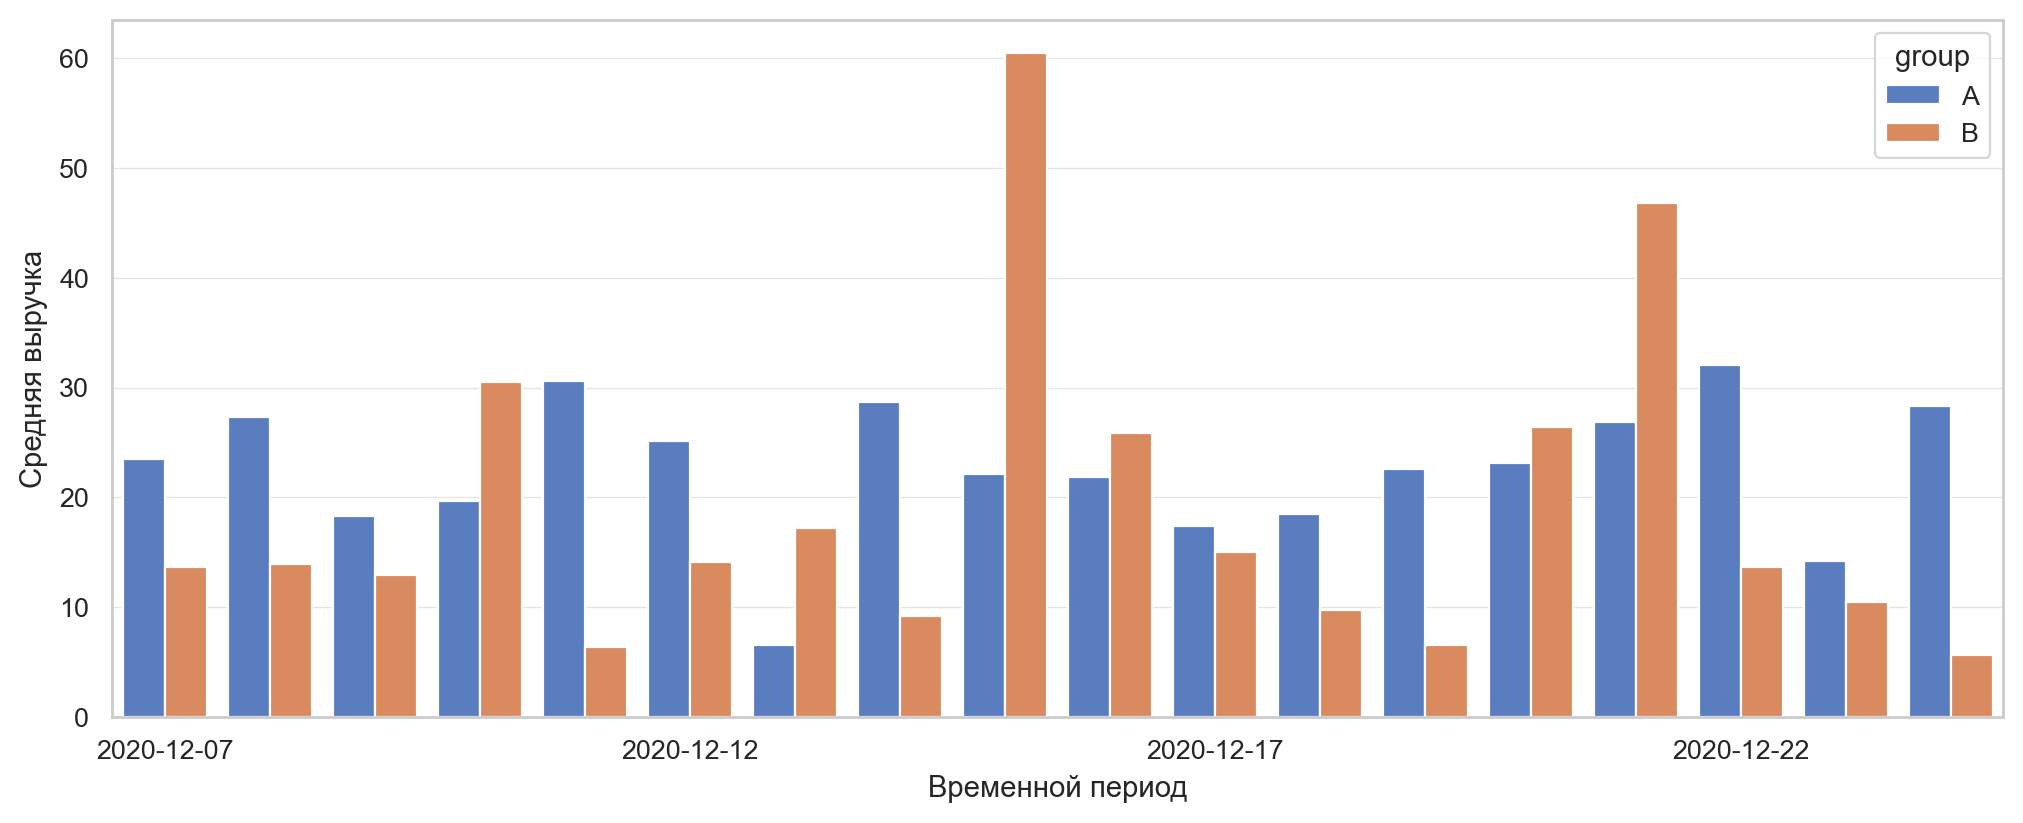

In [35]:
ax = sns.barplot(x='event_dt', y='avg_revenue', hue='group',
                 data=view.query('event_name == "purchase"'), estimator='sum')

for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % 5 != 0:
        label.set_visible(False)

ax.set_ylabel('Средняя выручка')
ax.set_xlabel('Временной период');
plt.show()

# Вывод

* В ходе A/B-теста не удалось показать улучшение каждой метрики не менее, чем на 10%.
* Правильность проведения теста вызывает сомнения, следует учесть выявленные нарушения и провести повторный тест.